# Assignment2
### - Anomaly detection 데이터셋을 SVM을 이용해서 판별해보자
### - 데이터 분포 : True : 0.17프로 나머지 다 False, Row약 28만행

In [1]:
# data
import numpy as np
import pandas as pd

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

# preprocessing
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler

# model
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

# evaluation
from sklearn.metrics import *
from tqdm import tqdm
from time import sleep
from sklearn.model_selection import cross_validate

In [2]:
# Anomaly detection(사기감지 데이터) 로드
df = pd.read_csv('anomaly-detection/creditcard.csv')
print(df.columns)

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')


In [3]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
df.shape

(284806, 31)

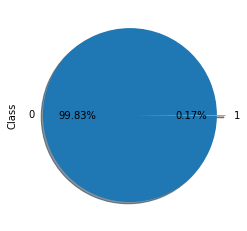

In [5]:
df['Class'].value_counts().plot.pie(explode=[0,0.1],autopct='%1.2f%%',shadow=True, labels =['0','1']) 
plt.show()

- 매우 Imbalance한 데이터임을 알 수 있다.
- Class 1(True) 인 경우가 0.17%로 매우 적다.

### 1. minority class를 oversampling하여 imbalance의 문제를 해결해보자

In [6]:
# 랜덤하게 20000개의 데이터를 뽑았다.
np.random.seed(0)
rndperm = np.random.permutation(df.shape[0])
df1=df.loc[rndperm[:20000],:]
df1.shape

(20000, 31)

In [7]:
df1.Class.value_counts()

0    19959
1       41
Name: Class, dtype: int64

In [8]:
X = df1.iloc[:, :-1]
y = df1.iloc[:, -1]

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1213)

In [10]:
train = pd.concat([X_train, y_train], axis=1)

In [11]:
# separate minority and majority classes
not_fraud = train[train.Class==0]
fraud = train[train.Class==1]

- minority class를 oversampling하는 과정

In [12]:
# upsample minority
fraud_upsampled = resample(fraud,
                          replace=True, # sample with replacement
                          n_samples=len(not_fraud), # match number in majority class
                          random_state=27) # reproducible results

In [13]:
# combine majority and upsampled minority
upsampled = pd.concat([not_fraud, fraud_upsampled])

In [14]:
# check new class counts
upsampled.Class.value_counts()

1    14966
0    14966
Name: Class, dtype: int64

In [15]:
y_train = upsampled.Class
X_train = upsampled.drop('Class', axis=1)

In [16]:
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns = X_test.columns)

In [17]:
#default linear
svc=SVC(kernel='linear') 
svc.fit(X_train,y_train) 
y_pred=svc.predict(X_test) 
print("Accuracy: ", accuracy_score(y_test,y_pred))
print("Confusion Matrix: ")
print(confusion_matrix(y_test, y_pred))
print()
print("Precision: ", precision_score(y_test, y_pred))
print("Recall: ", recall_score(y_test, y_pred))
print("f1 Score: ", f1_score(y_test, y_pred))

Accuracy:  0.9862
Confusion Matrix: 
[[4925   68]
 [   1    6]]

Precision:  0.08108108108108109
Recall:  0.8571428571428571
f1 Score:  0.14814814814814817


In [18]:
#default RBF kernel
svc2=SVC(kernel='rbf')
svc2.fit(X_train,y_train)
y_pred2=svc2.predict(X_test)
print("Accuracy: ", accuracy_score(y_test,y_pred2))
print("Confusion Matrix: ")
print(confusion_matrix(y_test, y_pred2))
print()
print("Precision: ", precision_score(y_test, y_pred2))
print("Recall: ", recall_score(y_test, y_pred2))
print("f1 Score: ", f1_score(y_test, y_pred2))

Accuracy:  0.9954
Confusion Matrix: 
[[4973   20]
 [   3    4]]

Precision:  0.16666666666666666
Recall:  0.5714285714285714
f1 Score:  0.25806451612903225


In [ ]:
C_range=list(np.arange(1,80,1))
acc_score = []

for c in tqdm(C_range):
    svc = SVC(kernel='linear', gamma='auto', C=c)
    svc.fit(X_train,y_train)
    scores = cross_validate(svc, X, y, cv=5, scoring='accuracy') # 점수를 리스트로 관리해줍니다.
    score = np.mean(scores['test_score']) #5개 스코어 값의 평균
    acc_score.append(score) 

In [ ]:
print(np.max(acc_score)) #제일 좋은 결과
print(C_range[np.argmax(acc_score)]) #제일 좋은 결과가 나온 파라미터

In [ ]:
C_range=list(np.arange(1,80,1))
plt.plot(C_range,acc_score)
plt.xticks(np.arange(0,100,5))
plt.xlabel('Value of C for SVC')
plt.ylabel('Cross-Validated Accuracy Score')

In [19]:
svm_over = SVC(kernel = 'linear', gamma = 3, C = 20)
svm_over.fit(X_train,y_train)
y_pred=svm_over.predict(X_test)
print("Accuracy: ", accuracy_score(y_test,y_pred))
print("Confusion Matrix: ")
print(confusion_matrix(y_test, y_pred))
print()
print("Precision: ", precision_score(y_test, y_pred))
print("Recall: ", recall_score(y_test, y_pred))
print("f1 Score: ", f1_score(y_test, y_pred))

Accuracy:  0.987
Confusion Matrix: 
[[4930   63]
 [   2    5]]

Precision:  0.07352941176470588
Recall:  0.7142857142857143
f1 Score:  0.13333333333333333


- Accuracy는 매우 높지만 f1 score가 0에 가까워 매우 안좋은 결과임을 알 수 있다.
- 하지만 Recall이 1인 것으로 보아 사기인 경우는 모두 분류해냈음을 알 수 있다.

### 2. majority class를 undersampling하여 imbalance의 문제를 해결해보자

In [6]:
X2 = df.iloc[:, :-1]
y2 = df.iloc[:, -1]

In [7]:
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X2, y2, random_state=1213)

In [8]:
X_train_2.shape, X_test_2.shape

((213604, 30), (71202, 30))

In [9]:
train_2 = pd.concat([X_train_2, y_train_2], axis=1)

In [10]:
# separate minority and majority classes
not_fraud = train_2[train_2.Class==0]
fraud = train_2[train_2.Class==1]

- majority class를 undersampling하여 imbalance의 문제를 해결해보기로 하였다.

In [11]:
# downsample majority
not_fraud_downsampled = resample(not_fraud,
                                replace = False, # sample without replacement
                                n_samples = len(fraud), # match minority n
                                random_state = 27) # reproducible results

In [12]:
# combine minority and downsampled majority
downsampled = pd.concat([not_fraud_downsampled, fraud])

In [13]:
# checking counts
downsampled.Class.value_counts()

1    359
0    359
Name: Class, dtype: int64

In [14]:
y_train_2 = downsampled.Class
X_train_2 = downsampled.drop('Class', axis=1)

In [15]:
scaler = StandardScaler()
X_train_2 = pd.DataFrame(scaler.fit_transform(X_train_2), columns = X_train_2.columns)
X_test_2 = pd.DataFrame(scaler.transform(X_test_2), columns = X_test_2.columns)

In [17]:
#default linear
svc=SVC(kernel='linear') 
svc.fit(X_train_2,y_train_2) 
y_pred=svc.predict(X_test_2) 
print("Accuracy: ", accuracy_score(y_test_2,y_pred))
print("Confusion Matrix: ")
print(confusion_matrix(y_test_2, y_pred))
print()
print("Precision: ", precision_score(y_test_2, y_pred))
print("Recall: ", recall_score(y_test_2, y_pred))
print("f1 Score: ", f1_score(y_test_2, y_pred))

Accuracy:  0.9691862588129547
Confusion Matrix: 
[[68885  2184]
 [   10   123]]

Precision:  0.053315994798439535
Recall:  0.924812030075188
f1 Score:  0.10081967213114754


In [18]:
#default RBF kernel
svc2=SVC(kernel='rbf')
svc2.fit(X_train_2,y_train_2)
y_pred2=svc2.predict(X_test_2)
print("Accuracy: ", accuracy_score(y_test_2,y_pred2))
print("Confusion Matrix: ")
print(confusion_matrix(y_test_2, y_pred2))
print()
print("Precision: ", precision_score(y_test_2, y_pred2))
print("Recall: ", recall_score(y_test_2, y_pred2))
print("f1 Score: ", f1_score(y_test_2, y_pred2))

Accuracy:  0.9748883458329822
Confusion Matrix: 
[[69293  1776]
 [   12   121]]

Precision:  0.06378492356352135
Recall:  0.9097744360902256
f1 Score:  0.11921182266009853


- gamma 값을 0.01로 tuning하여 결과를 확인해보았다.

In [33]:
svm_under = SVC(kernel = 'linear', gamma = 0.01, C = 1)
svm_under.fit(X_train_2,y_train_2)
y_pred=svm_under.predict(X_test_2)
print("Accuracy: ", accuracy_score(y_test_2,y_pred))
print("Confusion Matrix: ")
print(confusion_matrix(y_test_2, y_pred))
print()
print("Precision: ", precision_score(y_test_2, y_pred))
print("Recall: ", recall_score(y_test_2, y_pred_under))
print("f1 Score: ", f1_score(y_test_2, y_pred_under))

Accuracy:  0.9691862588129547
Confusion Matrix: 
[[68885  2184]
 [   10   123]]

Precision:  0.053315994798439535
Recall:  0.924812030075188
f1 Score:  0.10081967213114754


In [34]:
svm_under = SVC(kernel = 'rbf', gamma = 0.01, C = 1)
svm_under.fit(X_train_2,y_train_2)
y_pred=svm_under.predict(X_test_2)
print("Accuracy: ", accuracy_score(y_test_2,y_pred))
print("Confusion Matrix: ")
print(confusion_matrix(y_test_2, y_pred))
print()
print("Precision: ", precision_score(y_test_2, y_pred))
print("Recall: ", recall_score(y_test_2, y_pred))
print("f1 Score: ", f1_score(y_test_2, y_pred))

Accuracy:  0.9878514648464931
Confusion Matrix: 
[[70218   851]
 [   14   119]]

Precision:  0.12268041237113401
Recall:  0.8947368421052632
f1 Score:  0.2157751586582049
